In [1]:
import tensorflow as tf

# You'll generate plots of attention in order to see which parts of an image
# your model focuses on during captioning
import matplotlib.pyplot as plt

import collections
import random
import numpy as np
from PIL import Image

#importing local module 
from models.subclasses import *
from models.utilities import *
from models.train import *

In [2]:
# Train sample size (-1 for max)
sample = 100

## Importing data

In [3]:
#image_path_to_caption = [item.replace("\\","/") for item in image_path_to_caption] #windows
image_path_to_caption = import_files()
image_paths = list(image_path_to_caption.keys())
random.shuffle(image_paths)

# Select the first 6000 image_paths from the shuffled set.
# Approximately each image id has 5 captions associated with it, so that will
# lead to 30,000 examples.
train_image_paths = image_paths[:sample]
#train_image_paths = [item.replace("\\","/") for item in train_image_paths] #windows
print(len(train_image_paths))

100


## Prepair data

In [4]:
train_captions = []
img_name_vector = []
for image_path in train_image_paths:
  caption_list = image_path_to_caption[image_path]
  train_captions.extend(caption_list)
  img_name_vector.extend([image_path] * len(caption_list))

# print(train_captions[0])
# Image.open(img_name_vector[0])

## Prepair the models

In [5]:
image_model = tf.keras.applications.resnet50.ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

In [6]:
# freeze layers
for layer in image_features_extract_model.layers[:]:
    layer.trainable = False

In [7]:
image_features_extract_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [8]:
# Get unique images
encode_train = sorted(set(img_name_vector))

# Feel free to change batch_size according to your system configuration
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(32)

for img, path in image_dataset:
    batch_features = image_features_extract_model(img) #Kernal dies here :D
    batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

    for bf, p in zip(batch_features, path):
        path_of_feature = p.numpy().decode("utf-8")
        np.save(path_of_feature, bf.numpy())

In [9]:
caption_dataset = tf.data.Dataset.from_tensor_slices(train_captions)

# We will override the default standardization of TextVectorization to preserve
# "<>" characters, so we preserve the tokens for the <start> and <end>.
def standardize(inputs):
  inputs = tf.strings.lower(inputs)
  return tf.strings.regex_replace(inputs,
                                  r"!\"#$%&\(\)\*\+.,-/:;=?@\[\\\]^_`{|}~", "")

# Max word count for a caption.
max_length = 15
# Use the top 5000 words for a vocabulary.
vocabulary_size = 20000
tokenizer = tf.keras.layers.TextVectorization(
    max_tokens=vocabulary_size,
    standardize=standardize,
    output_sequence_length=max_length)
# Learn the vocabulary from the caption data.
tokenizer.adapt(caption_dataset)

# Create the tokenized vectors
cap_vector = caption_dataset.map(lambda x: tokenizer(x))

In [10]:
# Create mappings for words to indices and indicies to words.
word_to_index = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary())
index_to_word = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary(),
    invert=True)

In [11]:
img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(img_name_vector, cap_vector):
  img_to_cap_vector[img].append(cap)

# Create training and validation sets using an 80-20 split randomly.
img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)

slice_index = int(len(img_keys)*0.8)
img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:]

img_name_train = []
cap_train = []
for imgt in img_name_train_keys:
  capt_len = len(img_to_cap_vector[imgt])
  img_name_train.extend([imgt] * capt_len)
  cap_train.extend(img_to_cap_vector[imgt])

img_name_val = []
cap_val = []
for imgv in img_name_val_keys:
  capv_len = len(img_to_cap_vector[imgv])
  img_name_val.extend([imgv] * capv_len)
  cap_val.extend(img_to_cap_vector[imgv])

len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(400, 400, 100, 100)

In [12]:
# Feel free to change these parameters according to your system's configuration
BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 224
units = 512
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 49

# Training parameters
epochs = 20
num_steps = len(img_name_train) // BATCH_SIZE

In [13]:
# Load the numpy files
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap

dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int64]),
          num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

## Making the models

In [14]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, tokenizer.vocabulary_size())

## Training

In [15]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [16]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)

In [17]:
train_RNN(epochs, start_epoch, ckpt_manager, num_steps,
              dataset, decoder, encoder, word_to_index)

Epoch 1 Batch 0 Loss 5.2259
Epoch 1 Loss 5.249129
Time taken for 1 epoch 27.38 sec

Epoch 2 Batch 0 Loss 3.9075
Epoch 2 Loss 4.555182
Time taken for 1 epoch 0.74 sec

Epoch 3 Batch 0 Loss 3.8306
Epoch 3 Loss 4.423468
Time taken for 1 epoch 0.84 sec

Epoch 4 Batch 0 Loss 3.6505
Epoch 4 Loss 4.245697
Time taken for 1 epoch 0.81 sec

Epoch 5 Batch 0 Loss 3.4410
Epoch 5 Loss 3.956751
Time taken for 1 epoch 0.87 sec

Epoch 6 Batch 0 Loss 3.1214
Epoch 6 Loss 3.592944
Time taken for 1 epoch 1.37 sec

Epoch 7 Batch 0 Loss 2.7058
Epoch 7 Loss 3.204007
Time taken for 1 epoch 0.82 sec

Epoch 8 Batch 0 Loss 2.5779
Epoch 8 Loss 2.911738
Time taken for 1 epoch 0.70 sec

Epoch 9 Batch 0 Loss 2.2768
Epoch 9 Loss 2.637847
Time taken for 1 epoch 0.82 sec

Epoch 10 Batch 0 Loss 2.0802
Epoch 10 Loss 2.429385
Time taken for 1 epoch 0.71 sec

Epoch 11 Batch 0 Loss 1.8102
Epoch 11 Loss 2.259802
Time taken for 1 epoch 1.20 sec

Epoch 12 Batch 0 Loss 1.7052
Epoch 12 Loss 2.089474
Time taken for 1 epoch 0.70 se

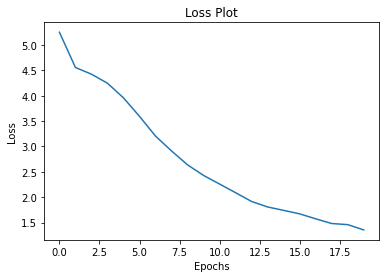

In [18]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

## Result

In [19]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tf.compat.as_text(index_to_word(i).numpy())
                         for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image, max_length, attention_features_shape, encoder, decoder,
             image_features_extract_model, word_to_index, index_to_word)

print('Real Caption:', real_caption)
print('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)

Real Caption: <start> a laptop sits on a bed in a dark room. <end>
Prediction Caption: a meal <end>
